In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import shap

In [2]:
df_train_minmax = pd.HDFStore("../../cloudcontainer/concatenated_experiments.hdf5", mode='r').select("alldata_mean_instead_of_NaN/train/minmax")
df_val_minmax = pd.HDFStore("../../cloudcontainer/concatenated_experiments.hdf5", mode='r').select("alldata_mean_instead_of_NaN/val/minmax")
df_test_minmax = pd.HDFStore("../../cloudcontainer/concatenated_experiments.hdf5", mode='r').select("alldata_mean_instead_of_NaN/test/minmax")

df_pressure_train_minmax = df_train_minmax["pressure"]
df_pressure_val_minmax = df_val_minmax["pressure"]
df_pressure_test_minmax = df_test_minmax["pressure"]

df_ae_train_minmax = df_train_minmax["ae"]
df_ae_val_minmax = df_val_minmax["ae"]
df_ae_test_minmax = df_test_minmax["ae"]

df_train_minmax = df_train_minmax.drop(["pressure"], axis=1)
df_val_minmax = df_val_minmax.drop(["pressure"], axis=1)
df_test_minmax = df_test_minmax.drop(["pressure"], axis=1)

'''
df_train_minmax = df_train_minmax.drop(["ae"], axis=1)
df_val_minmax = df_val_minmax.drop(["ae"], axis=1)
df_test_minmax = df_test_minmax.drop(["ae"], axis=1)
'''

np_train_minmax = df_train_minmax.to_numpy()
np_val_minmax = df_val_minmax.to_numpy()
np_test_minmax = df_test_minmax.to_numpy()
np_pressure_train_minmax = df_pressure_train_minmax.to_numpy()
np_pressure_val_minmax = df_pressure_val_minmax.to_numpy()
np_pressure_test_minmax = df_pressure_test_minmax.to_numpy()
np_ae_train_minmax = df_ae_train_minmax.to_numpy()
np_ae_val_minmax = df_ae_val_minmax.to_numpy()
np_ae_test_minmax = df_ae_test_minmax.to_numpy()

In [3]:
train_len = len(df_train_minmax)
val_len = len(df_val_minmax)

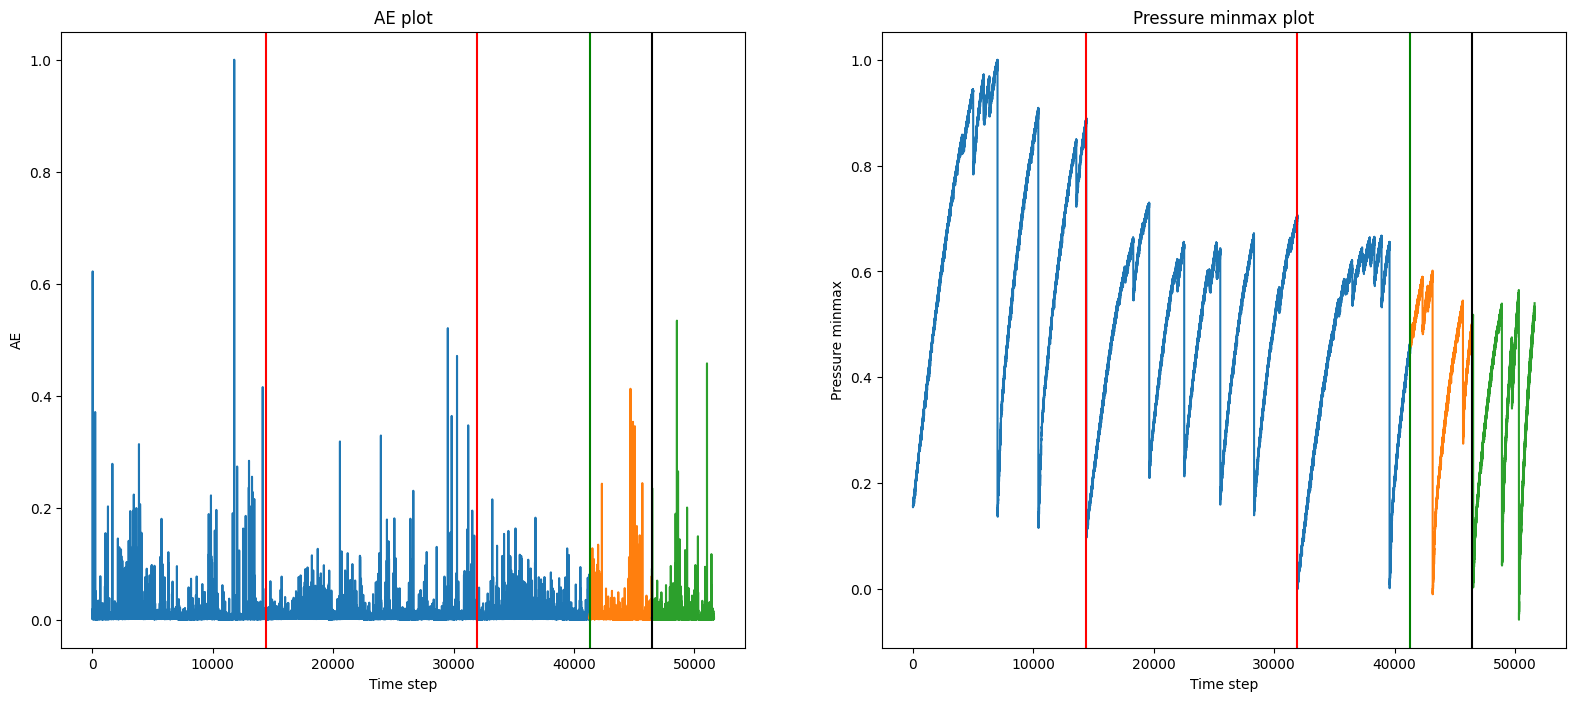

In [4]:
fig = plt.figure(figsize=(30,8))
ax1 = fig.add_subplot(131)
plt.plot(df_ae_train_minmax)
plt.plot(df_ae_val_minmax)
plt.plot(df_ae_test_minmax)
plt.title("AE plot")
plt.ylabel('AE')
plt.xlabel('Time step')
plt.axvline(x=14400, color='r')
plt.axvline(x=14400+17515, color='r')
plt.axvline(x=train_len, color='g')
plt.axvline(x=train_len+val_len, color='black')

ax2 = fig.add_subplot(132)
plt.plot(df_pressure_train_minmax)
plt.plot(df_pressure_val_minmax)
plt.plot(df_pressure_test_minmax)
plt.title("Pressure minmax plot")
plt.ylabel('Pressure minmax')
plt.xlabel('Time step')
plt.axvline(x=14400, color='r')
plt.axvline(x=14400+17515, color='r')
plt.axvline(x=train_len, color='g')
plt.axvline(x=train_len+val_len, color='black')

train mse:  1.7832567242476523e-05
val mse:  0.014972438594631546
test mse:  0.015177465728321666


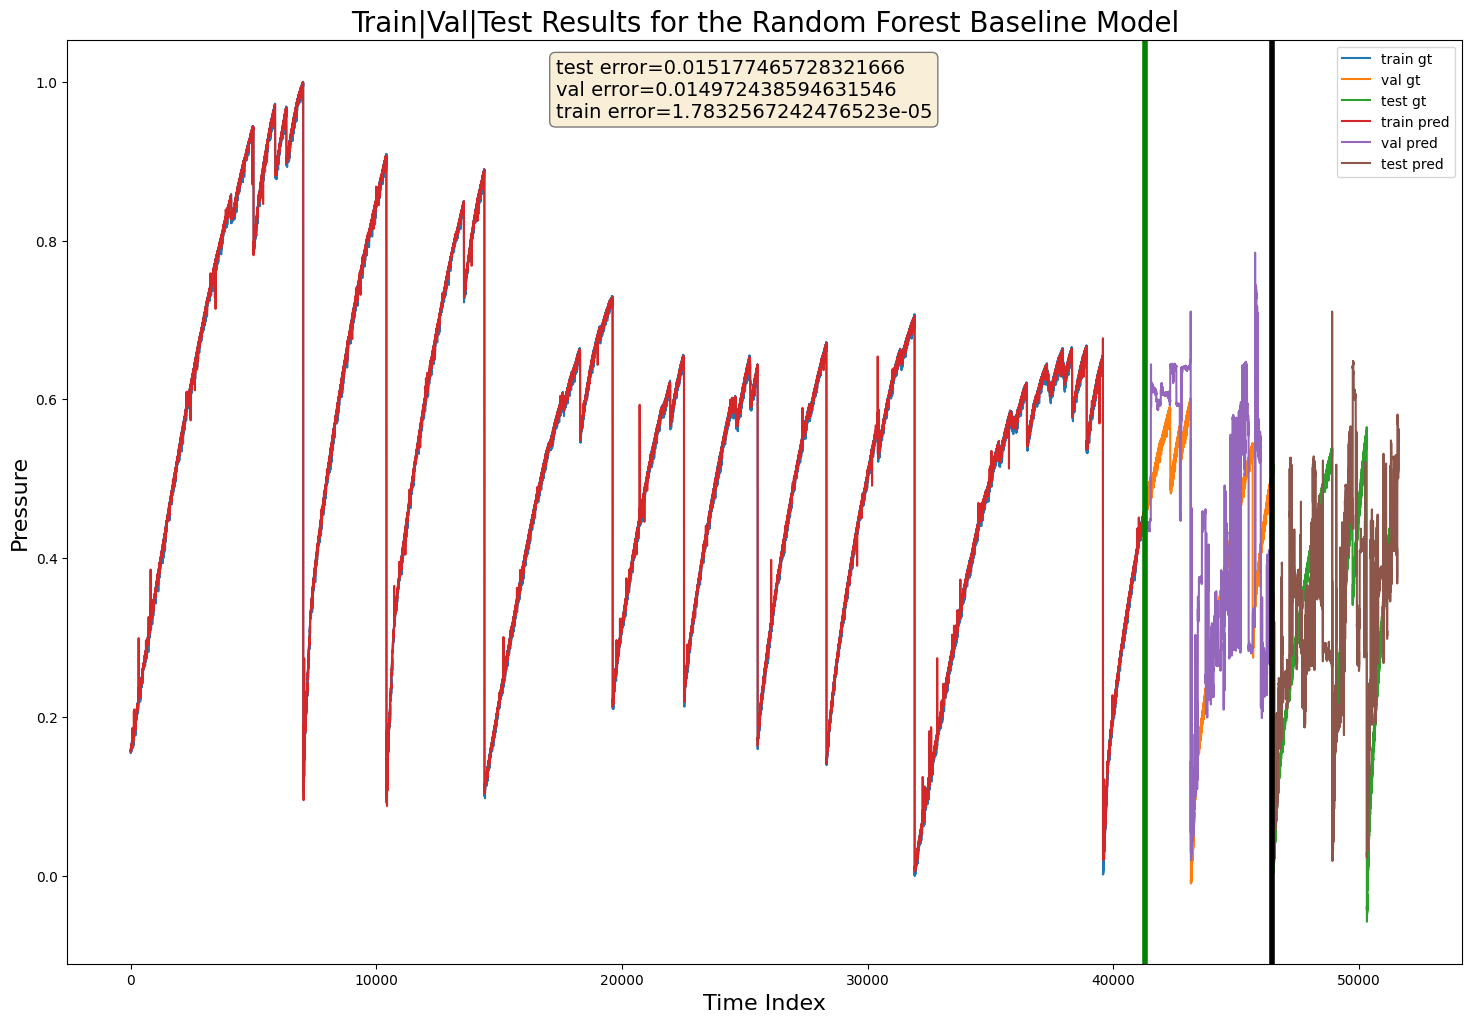

In [5]:
baseline_rf_seismology_model = RandomForestRegressor()

search_grid = {
    'max_features': ['auto'],
}

baseline_rf_seismology_model_random = RandomizedSearchCV(estimator=baseline_rf_seismology_model, param_distributions=search_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
# n_jobs=-1 means use all processors.

baseline_rf_seismology_model.fit(np_train_minmax, np_pressure_train_minmax) 
# Note that I use the default tol (tolerance) parameter here. 

np_predictions_train = baseline_rf_seismology_model.predict(np_train_minmax)
df_predictions_train = pd.DataFrame(np_predictions_train)

np_predictions_val = baseline_rf_seismology_model.predict(np_val_minmax)
df_predictions_val = pd.DataFrame(np_predictions_val, index=[i for i in range(len(np_train_minmax), len(np_train_minmax)+len(np_predictions_val))])

np_predictions_test = baseline_rf_seismology_model.predict(np_test_minmax)
df_predictions_test = pd.DataFrame(np_predictions_test, index=[i for i in range(len(np_train_minmax)+len(np_predictions_val), len(np_train_minmax)+len(np_predictions_val)+len(np_predictions_test))])

# Use sklearn MSE metrics to compare with the deep learning model
# using the same exact implementation of the metric:
mse_train = metrics.mean_squared_error(np_pressure_train_minmax, np_predictions_train)
mse_val = metrics.mean_squared_error(np_pressure_val_minmax, np_predictions_val)
mse_test = metrics.mean_squared_error(np_pressure_test_minmax, np_predictions_test)
print("train mse: ", mse_train)
print("val mse: ", mse_val)
print("test mse: ", mse_test)
best_model_parameters = baseline_rf_seismology_model.get_params()

fig, ax = plt.subplots(figsize=(18,12))
ax.plot(df_pressure_train_minmax, label="train gt")
ax.plot(df_pressure_val_minmax, label="val gt")
ax.plot(df_pressure_test_minmax, label="test gt")

ax.plot(df_predictions_train, label="train pred")
ax.plot(df_predictions_val, label="val pred")
ax.plot(df_predictions_test, label="test pred")

ax.axvline(x=train_len, color='g', lw=4)
ax.axvline(x=train_len+val_len, color='black', lw=4)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text_box_str = f"test error={mse_test}" + f"\nval error={mse_val}" + f"\ntrain error={mse_train}"
ax.text(0.35, 0.98, text_box_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

ax.set_title(f"Train|Val|Test Results for the Random Forest Baseline Model", fontsize=20)
ax.set_xlabel("Time Index", fontsize=16)
ax.set_ylabel("Pressure", fontsize=16)
plt.legend()
plt.savefig(f"../../cloudcontainer/experiments_related/randomforestmodel_n_estimators={str(best_model_parameters['n_estimators'])}.png")

In [6]:
'''
# Info about masker: 
# https://stackoverflow.com/questions/66560839/what-do-maskers-really-do-in-shap-package-and-fit-them-to-train-or-test
masker = shap.maskers.Independent(data=df_train_minmax)
explainer = shap.TreeExplainer(baseline_rf_seismology_model, masker=masker)
shap_values = explainer(df_test_minmax)
print(shap_values)
'''

'\n# Info about masker: \n# https://stackoverflow.com/questions/66560839/what-do-maskers-really-do-in-shap-package-and-fit-them-to-train-or-test\nmasker = shap.maskers.Independent(data=df_train_minmax)\nexplainer = shap.TreeExplainer(baseline_rf_seismology_model, masker=masker)\nshap_values = explainer(df_test_minmax)\nprint(shap_values)\n'

In [7]:
#shap.plots.bar(shap_values)

In [8]:
#plt.savefig(f"../../cloudcontainer/experiments_related/explanation_for_randomforestmodel_n_estimators={str(best_model_parameters['n_estimators'])}.png")